In [65]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image
import keras
import random
import pandas as pd
import tensorflow

# Monkey Species Classification

# Approach:
- Extraction of the features using VGG16
- Random Forest for the Classification

In [66]:
def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    np.random.seed(seed_value)
    random.seed(seed_value)
set_seed(42)

In [67]:
os.environ['KERAS_BACKEND'] = 'tensorflow' # Added to set the backend as Tensorflow

In [68]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input

# Defining the transformations!
training_datagen = ImageDataGenerator( preprocessing_function= preprocess_input)
validation_datagen = ImageDataGenerator(preprocessing_function= preprocess_input)

In [69]:
train_generator = training_datagen.flow_from_directory(
        '/Users/simoneboesso/Desktop/MonkeySpeciesClassification_TransferKnowledge-RandomForest/MonkeySpecies_Dataset/training/training',  # this is the input directory
        target_size=(224, 224),  
        batch_size=32,
        shuffle = True,
        class_mode='categorical')  

# this is a similar generator, for validation data
validation_generator = validation_datagen.flow_from_directory(
    "/Users/simoneboesso/Desktop/MonkeySpeciesClassification_TransferKnowledge-RandomForest/MonkeySpecies_Dataset/validation/validation",
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical'
)

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [71]:
#instantiate a base model with pre-trained weigts.
base_model=keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3))

In [72]:
base_model.trainable = False
base_model.summary()  #Trainable parameters will be 0

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [73]:
# Extract features using the base model
features = []
labels = []

for i in range(len(train_generator)):
    imgs, lbls = next(train_generator)
    feats = base_model.predict(imgs)
    features.append(feats)
    labels.append(lbls)

# Convert lists to single numpy arrays
features = np.vstack(features)
labels = np.vstack(labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 

In [74]:
features = features.reshape(features.shape[0], -1)
features.shape

(1098, 25088)

In [94]:
# Assuming `labels` is your one-hot encoded labels array with shape (1098, 10)
integer_labels = np.argmax(labels, axis=1)

print("Converted integer labels shape:", integer_labels.shape)

Converted integer labels shape: (1098,)


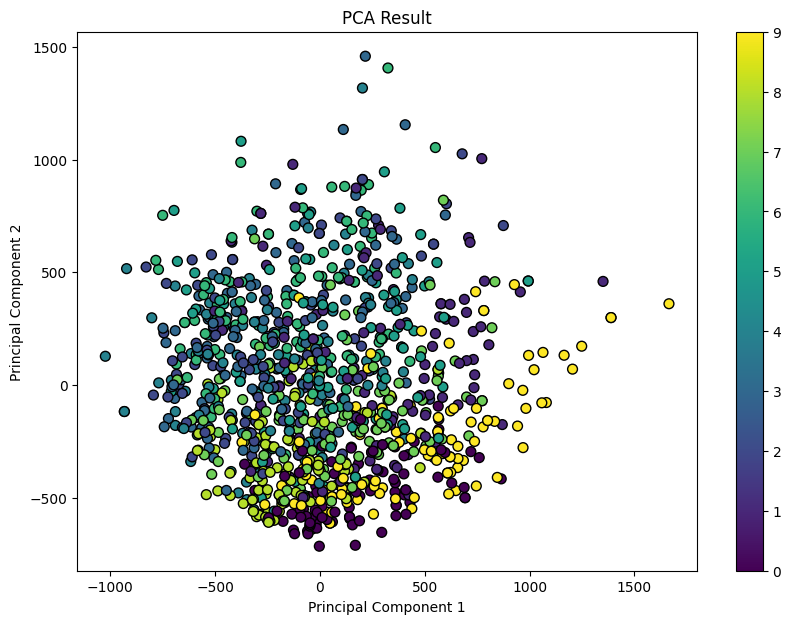

In [96]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
pca_result = pca.fit_transform(features)
plt.figure(figsize=(10, 7))
plt.scatter(pca_result[:, 0], pca_result[:,1], c= integer_labels, cmap='viridis', edgecolor='k', s=50)
plt.colorbar()  # To show the color scale which corresponds to different classes
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Result')
plt.show()


In [91]:
# Check labels type and shape
print("Labels type:", type(labels))
print("Labels shape:", labels.shape)  # Should be (1098,)

Labels type: <class 'numpy.ndarray'>
Labels shape: (1098, 10)


In [92]:
integer_labels = np.argmax(labels, axis=1)

print("Converted integer labels shape:", integer_labels.shape)

Converted integer labels shape: (1098,)


# Let's apply the Random Forest on the features found!

In [97]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(features, integer_labels) 

RandomForestClassifier()

# Test time

In [98]:
# Extract features using the base model
features_test = []
labels_test = []

for i in range(len(validation_generator)):
    imgs, lbls = next(validation_generator)
    feats = base_model.predict(imgs)
    features_test.append(feats)
    labels_test.append(lbls)

# Convert lists to single numpy arrays
features_test = np.vstack(features_test)
labels_test = np.vstack(labels_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [99]:
features_test.shape

(272, 7, 7, 512)

In [101]:
X_test_features = features_test.reshape(features_test.shape[0], -1)

In [102]:
prediction_RF = rf_model.predict(X_test_features)

In [103]:
prediction_RF

array([4, 6, 6, 2, 6, 7, 6, 0, 5, 4, 2, 0, 0, 0, 9, 3, 5, 6, 3, 4, 5, 2,
       7, 1, 3, 5, 8, 7, 7, 8, 3, 0, 0, 1, 6, 3, 6, 2, 1, 1, 0, 1, 7, 5,
       1, 0, 2, 1, 3, 0, 1, 4, 8, 0, 0, 0, 4, 0, 4, 7, 9, 2, 2, 3, 6, 8,
       4, 5, 4, 8, 6, 9, 0, 6, 8, 4, 6, 7, 6, 3, 1, 5, 8, 3, 0, 5, 7, 9,
       3, 3, 2, 2, 9, 2, 7, 8, 5, 0, 2, 7, 8, 2, 2, 0, 7, 2, 7, 4, 5, 3,
       4, 8, 7, 2, 8, 3, 4, 8, 6, 4, 9, 3, 4, 2, 4, 3, 2, 2, 6, 2, 3, 9,
       5, 9, 5, 6, 8, 3, 5, 1, 9, 0, 3, 7, 2, 7, 8, 3, 2, 4, 3, 1, 8, 9,
       4, 5, 1, 5, 7, 7, 8, 0, 9, 9, 1, 3, 0, 5, 6, 9, 0, 1, 7, 2, 1, 5,
       1, 2, 5, 7, 1, 3, 9, 0, 9, 6, 6, 8, 7, 6, 6, 7, 1, 8, 1, 0, 5, 7,
       2, 8, 8, 1, 1, 2, 5, 0, 6, 6, 0, 7, 0, 1, 0, 0, 6, 4, 9, 4, 0, 5,
       4, 8, 5, 5, 7, 8, 0, 9, 2, 2, 5, 7, 1, 8, 1, 8, 3, 9, 6, 9, 3, 9,
       8, 0, 3, 9, 3, 0, 3, 8, 7, 8, 7, 4, 8, 9, 3, 4, 3, 3, 4, 9, 3, 0,
       1, 4, 7, 4, 1, 1, 4, 0])

In [108]:
integer_labels_test = np.argmax(labels_test, axis=1)
print("Converted integer labels shape:", integer_labels_test.shape)

Converted integer labels shape: (272,)


In [109]:
integer_labels_test.shape

(272,)

In [110]:
prediction_RF.shape

(272,)

In [111]:
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(integer_labels_test, prediction_RF))

Accuracy =  0.9411764705882353


In [112]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import classification_report
cm = classification_report(integer_labels_test, prediction_RF)
print(cm)

              precision    recall  f1-score   support

           0       0.76      1.00      0.87        26
           1       0.93      0.89      0.91        28
           2       0.96      0.96      0.96        27
           3       0.97      1.00      0.98        30
           4       0.96      0.96      0.96        26
           5       1.00      0.86      0.92        28
           6       1.00      0.92      0.96        26
           7       0.96      0.96      0.96        28
           8       0.93      0.96      0.95        27
           9       1.00      0.88      0.94        26

    accuracy                           0.94       272
   macro avg       0.95      0.94      0.94       272
weighted avg       0.95      0.94      0.94       272



# Testing on a random image

In [115]:
'''
This is a function for deprocessing an image transformed with preprocess_input (vg16)
'''
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  # perform the inverse of the preprocessiing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [139]:
''' function for getting back the original names from the label'''
def change_label_names(label):
    label = str(label)
    if "n" in label:
        label = label.strip("n")
    index = {'0': 'mantled_howler', '1': 'patas_monkey', '2': 'bald_uakari', '3': 'japanese_macaque', 
        '4': 'pygmy_marmoset', '5': 'white_headed_capuchin', '6': 'silvery_marmoset', 
        '7': 'common_squirrel_monkey', '8': 'black_headed_night_monkey', '9': 'nilgiri_langur'}
    return index[label]

Found 272 images belonging to 10 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
The prediction for this image is:  mantled_howler
The actual label for this image is:  mantled_howler


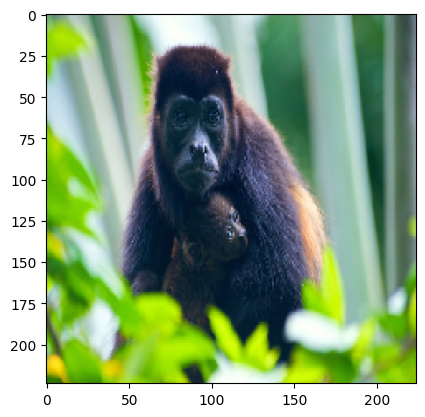

In [156]:
# Create a generator for single images
test_generator = validation_datagen.flow_from_directory(
    "/Users/simoneboesso/Desktop/MonkeySpeciesClassification_TransferKnowledge-RandomForest/MonkeySpecies_Dataset/validation/validation",
    target_size=(224, 224),
    batch_size=1,  # Process one image at a time
    class_mode='categorical',
    shuffle=True  # Shuffle to get random images
)

# Fetch a single image
img, label = next(test_generator)

d_img = deprocess_img(img)
plt.imshow(d_img)
# Prepare image for prediction
input_img_feature = base_model.predict(img)
input_img_feature = input_img_feature.reshape(input_img_feature.shape[0], -1)
prediction_RF = rf_model.predict(input_img_feature)
# Get the actual label (assuming label is categorical and one-hot encoded)
actual_label = test_generator.class_indices
actual_label = {v: k for k, v in actual_label.items()}
actual_label_name = actual_label[np.argmax(label)]

print("The prediction for this image is: ", change_label_names(prediction_RF[0]))
print("The actual label for this image is: ", change_label_names(actual_label_name))
